In [1]:
from src.data.get_dataset import get_merged_datasets
dataframe = get_merged_datasets()

dataframe.shape

(3104, 205)

In [27]:
numeric_cols = dataframe.select_dtypes(include=['number']).columns.difference(['year']).tolist() #we don't want year to be a feature in our prediction model
#we want to limit our feature set to columns without partial co2 data, since in real prediction we wouldn't know those values.
feature_list = [x for x in numeric_cols if "co2" not in x]
print(feature_list)

['Agricultural land Area in hectares', 'Cropland Area in hectares', 'Forest land Area in hectares', 'Median age', 'Population (historical estimates)', 'biofuel_cons_change_pct', 'biofuel_cons_change_twh', 'biofuel_cons_per_capita', 'biofuel_consumption', 'biofuel_elec_per_capita', 'biofuel_electricity', 'biofuel_share_elec', 'biofuel_share_energy', 'carbon_intensity_elec', 'coal_cons_change_pct', 'coal_cons_change_twh', 'coal_cons_per_capita', 'coal_consumption', 'coal_elec_per_capita', 'coal_electricity', 'coal_prod_change_pct', 'coal_prod_change_twh', 'coal_prod_per_capita', 'coal_production', 'coal_share_elec', 'coal_share_energy', 'electricity_demand', 'electricity_generation', 'electricity_share_energy', 'energy_cons_change_pct', 'energy_cons_change_twh', 'energy_per_capita', 'energy_per_gdp', 'fossil_cons_change_pct', 'fossil_cons_change_twh', 'fossil_elec_per_capita', 'fossil_electricity', 'fossil_energy_per_capita', 'fossil_fuel_consumption', 'fossil_share_elec', 'fossil_share_

In [28]:
#checking correlations between various features and co2 data
dataframe[feature_list + ['co2']].corr()['co2']

Agricultural land Area in hectares    0.764740
Cropland Area in hectares             0.761059
Forest land Area in hectares          0.422531
Median age                            0.178547
Population (historical estimates)     0.745872
                                        ...   
wind_electricity                      0.693358
wind_energy_per_capita                0.016839
wind_share_elec                       0.036186
wind_share_energy                    -0.018369
co2                                   1.000000
Name: co2, Length: 144, dtype: float64

In [116]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

X = dataframe[feature_list]
Y = dataframe['co2']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
simple_imputer = SimpleImputer(strategy='median')

#fit imputer on training set, and fit both train and test
simple_imputer.fit(X_train)


X_train = simple_imputer.transform(X_train)
X_test = simple_imputer.transform(X_test)

In [139]:
# Let's train a basic model for testing
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

linear_model = LinearRegression()
ridge_model = Ridge(random_state=42)
lasso_model = Lasso(random_state=42, tol=0.001) #reducing the tolerance so the model will converge
sgd_model = SGDRegressor(random_state=42)
decision_tree_model = DecisionTreeRegressor(random_state=42)
random_forest_model = RandomForestRegressor(random_state=42)

models = [linear_model, ridge_model, lasso_model, decision_tree_model, random_forest_model, sgd_model]
[x.fit(X_train, y_train) for x in models ] #train all models

[LinearRegression(),
 Ridge(random_state=42),
 Lasso(random_state=42, tol=0.001),
 DecisionTreeRegressor(random_state=42),
 RandomForestRegressor(random_state=42),
 SGDRegressor(random_state=42)]

In [140]:
training_predictions = [x.predict(X_train) for x in models]
mean_squared_errors = [mean_squared_error(y_train, x) for x in training_predictions]
r2_scores = [x.score(X_train, y_train) for x in models]
print([x.__class__.__name__ for x in models])
[print(f"Mean Squared Error: {x}") for x in mean_squared_errors]
[print(f"R2 score: {x}") for x in r2_scores]

['LinearRegression', 'Ridge', 'Lasso', 'DecisionTreeRegressor', 'RandomForestRegressor', 'SGDRegressor']
Mean Squared Error: 624.6552925551433
Mean Squared Error: 255.3428925865942
Mean Squared Error: 255.17215459331214
Mean Squared Error: 3.723102590841213e-36
Mean Squared Error: 208.92597714132262
Mean Squared Error: 7.068204461609074e+84
R2 score: 0.9987760505860414
R2 score: 0.9994996812042343
R2 score: 0.9995000157482129
R2 score: 1.0
R2 score: 0.9995906304960023
R2 score: -1.3849437940626587e+79


[None, None, None, None, None, None]

In [141]:
predictions = [x.predict(X_test) for x in models]
mean_squared_errors = [mean_squared_error(y_test, x) for x in predictions]
r2_scores = [x.score(X_test, y_test) for x in models]
print([x.__class__.__name__ for x in models])
[print(f"Mean Squared Error: {x}") for x in mean_squared_errors]
[print(f"R2 score: {x}") for x in r2_scores]

['LinearRegression', 'Ridge', 'Lasso', 'DecisionTreeRegressor', 'RandomForestRegressor', 'SGDRegressor']
Mean Squared Error: 1224.8563837381134
Mean Squared Error: 519.7408629656632
Mean Squared Error: 416.97318351394074
Mean Squared Error: 2824.7800753429933
Mean Squared Error: 659.9734953550529
Mean Squared Error: 2.0902810591267596e+65
R2 score: 0.998849894446239
R2 score: 0.9995119780074223
R2 score: 0.9996084739562158
R2 score: 0.9973476112824831
R2 score: 0.9993803035258497
R2 score: -1.9627148839167855e+59


[None, None, None, None, None, None]

In [127]:
#It seems lasso performed better than Random Forest Regression or gradient decent, so we might want to go with that going forward.
lasso_predictions = predictions[2]

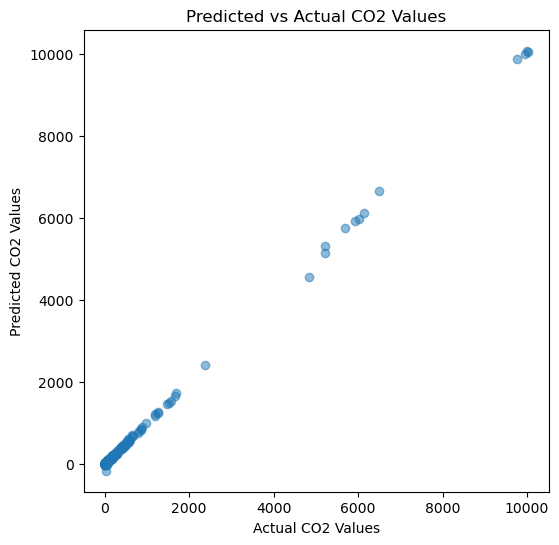

In [131]:
#Seems like Lasso performs the best which is to be expected.

import matplotlib.pyplot as plt

# Plotting predicted vs actual values
plt.figure(figsize=(6, 6))
plt.scatter(y_test, lasso_predictions, alpha=0.5)
plt.xlabel('Actual CO2 Values')
plt.ylabel('Predicted CO2 Values')
plt.title('Predicted vs Actual CO2 Values')
plt.show()

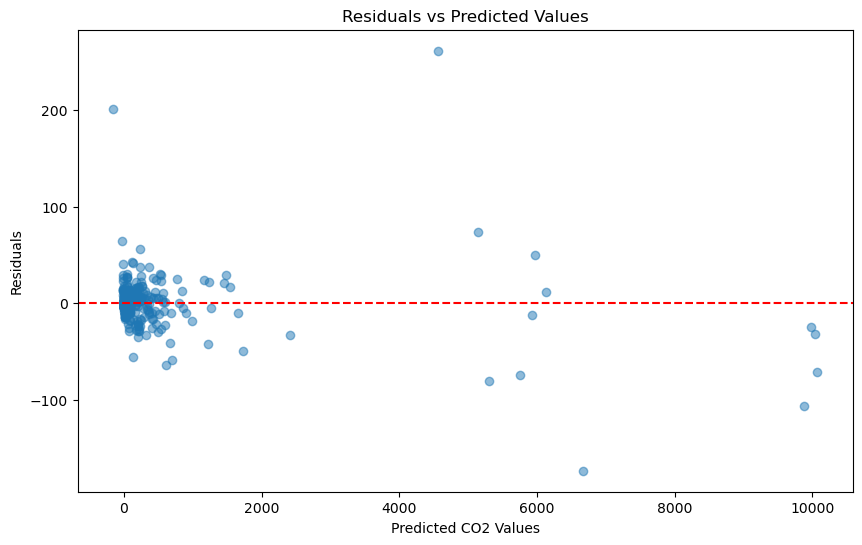

In [132]:
# Assuming you have your actual and predicted values as follows:
actual_values = y_test
predicted_values = lasso_predictions

# Calculate residuals
residuals = actual_values - predicted_values

# Plotting the residuals
plt.figure(figsize=(10, 6))
plt.scatter(predicted_values, residuals, alpha=0.5)
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted CO2 Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')  # Adds a horizontal line at zero
plt.show()

In [ ]:
#let's check what are predictors for lass regression were
